In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
# Define the transformations to apply to the images
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
img_size=227
Batch_size=16
# Load the dataset and split it into training and test sets
data_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Datasets/White Background/Photos Capstone',
    target_size=(img_size, img_size),
    batch_size=Batch_size,
    class_mode='categorical'
)

# Initialize empty arrays to hold the images and labels
X = np.empty((0, img_size, img_size, 3))
y = np.empty((0, 6))

# Iterate over the entire dataset
for x, label in data_generator:
    # Concatenate the images and labels to the arrays
    X = np.concatenate((X, x))
    y = np.concatenate((y, label))
    # Break the loop when all images have been processed
    if len(X) == data_generator.n:
        break
        
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Found 5209 images belonging to 6 classes.


In [ ]:
import keras
from keras.layers import Layer
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras.layers import (Conv2D, MaxPool2D,  
Dropout, Dense, Input, concatenate,    
GlobalAveragePooling2D, AveragePooling2D,  
Flatten) 
import cv2 
import numpy as np 
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler


In [ ]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [ ]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [ ]:
input_layer = Input(shape=(227, 227, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(6, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(128, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(6, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)

In [ ]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [ ]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 114, 114, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 57, 57, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                     

In [ ]:
epochs = 50
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), epochs=epochs, batch_size=256, callbacks=[lr_sc])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
17/17 [==============================] - 8s 254ms/step - loss: 1.5880 - output_loss: 0.9537 - auxilliary_output_1_loss: 1.0596 - auxilliary_output_2_loss: 1.0547 - output_accuracy: 0.5913 - auxilliary_output_1_accuracy: 0.5452 - auxilliary_output_2_accuracy: 0.5460 - val_loss: 1.6062 - val_output_loss: 1.0060 - val_auxilliary_output_1_loss: 0.9839 - val_auxilliary_output_2_loss: 1.0167 - val_output_accuracy: 0.5825 - val_auxilliary_output_1_accuracy: 0.6392 - val_auxilliary_output_2_accuracy: 0.5691 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
17/17 [==============================] - 4s 209ms/step - loss: 2.9366 - output_loss: 1.8492 - auxilliary_output_1_loss: 1.8432 - auxilliary_output_2_loss: 1.7814 - output_accuracy: 0.3141 - auxilliary_output_1_accuracy: 0.2925 - auxilliary_output_2_accuracy: 0.3117 - val_loss: 2.8654 - val_output_loss: 1.7922 - val_auxilliary_output

In [ ]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def ResNet34(shape = (img_size, img_size, 3), classes = 6):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [ ]:
#Sequential
model = ResNet34(shape = (img_size, img_size, 3), classes = 6)
# Compile the model with the loss function and optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store the training history
history = model.fit(X_train, y_train, epochs=10, batch_size=Batch_size, validation_data=(X_test, y_test))

Epoch 1/10
261/261 [==============================] - 14s 38ms/step - loss: 3.3306 - accuracy: 0.4171 - val_loss: 5.3279 - val_accuracy: 0.1699
Epoch 2/10
261/261 [==============================] - 9s 34ms/step - loss: 0.8967 - accuracy: 0.6676 - val_loss: 1.0535 - val_accuracy: 0.6219
Epoch 3/10
261/261 [==============================] - 9s 33ms/step - loss: 0.5940 - accuracy: 0.7857 - val_loss: 0.5736 - val_accuracy: 0.8100
Epoch 4/10
261/261 [==============================] - 9s 33ms/step - loss: 0.3912 - accuracy: 0.8635 - val_loss: 2.5945 - val_accuracy: 0.4750
Epoch 5/10
261/261 [==============================] - 9s 33ms/step - loss: 0.2736 - accuracy: 0.9042 - val_loss: 0.8041 - val_accuracy: 0.7207
Epoch 6/10
261/261 [==============================] - 9s 33ms/step - loss: 0.2318 - accuracy: 0.9189 - val_loss: 1.6672 - val_accuracy: 0.5681
Epoch 7/10
261/261 [==============================] - 9s 33ms/step - loss: 0.2055 - accuracy: 0.9318 - val_loss: 1.2480 - val_accuracy: 0.740

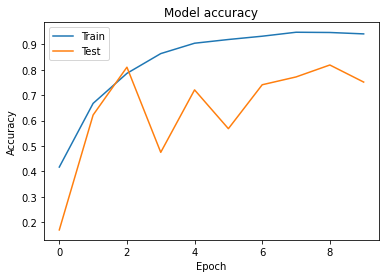

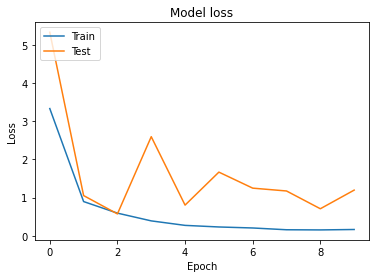

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Models/resNet_white_10_epoch.h5') 

In [ ]:
import pathlib
class_names = (data_generator.class_indices)
class_names = list((k) for k,v in class_names.items())
img = pathlib.Path('/content/drive/MyDrive/Testing/Mbeju/20220728190659716.jpg') 

img = tf.keras.utils.load_img(
    img, target_size=(img_size, img_size)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# # print(
# #     "This image most likely belongs to {} with a {:.2f} percent confidence."
# #     .format(class_names[np.argmax(score)], predictions[0])
# # )
# # print(class_names[np.argmax(score)], predictions[0])
# print('Name: ', class_names[np.argmax(score)], 'Conf: ', np.argmax(predictions[0]))
score_index = tf.argmax(predictions[0])
score =  predictions[0, score_index]
print('Class : ' , class_names[score_index], 'Conf: ', score)

1/1 [==============================] - 0s 24ms/step
Class :  Chipa guazú Conf:  1.0
